In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# **Capstone Project 1: Data Wrangling**

### **Problem Statement**   

Buying a house can be a very challenging process. It takes time, patience, and a lot of research to find a house that you like and then negotiate the right price for it. There are several features that influence house price such as the building type, total number of rooms, garage size, masonary work, location, utilities, and many more. Can house price be estimated (or predicted) using these features? Can we identify features that influence house price the most? How important is Building Type in determining the price? What influences the price more: location or size (sq.ft.)? How much value does remodeling add to the house? These are a few questions among many more that I intend to explore and answer.

### **Dataset**

Dataset is available on kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). It is the Ames Housing dataset, compiled by Dean De Cock. It has 1460 instances and 79 explanatory variables that describe almost every aspect of residential homes in Ames, Iowa.

## **1. Data Wrangling**

In this part, we will explore the data. In the process, we will clean and augment the data with additional information from other sources. We will perform the following steps:

- Identify and remove outliers
- Fill missing values
- Augment the dataset by collecting and adding data from other sources like Google's Geocoding API and uszipcode library

### Import useful libraries

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

### Load the dataset, and look at first few rows

In [3]:
housing_raw = pd.read_csv('../data/01-House-Price/train.csv',index_col='Id')
housing = housing_raw.copy()
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Datatype of each column

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

We can see there are a lot of numerical and categorical features.  
Lets first take look at the numerical (particularly continous) features to spot outliers.

### **1.1. Outliers**

In [5]:
# Created a list of continous features to check their distribution and spot potential outliers
cont_feats = ['SalePrice','LotFrontage',
              'LotArea','MasVnrArea',
              'BsmtFinSF1','BsmtFinSF2',
              'BsmtUnfSF','TotalBsmtSF',
              '1stFlrSF','2ndFlrSF',
              'LowQualFinSF','GrLivArea',
              'GarageArea','WoodDeckSF',
              'OpenPorchSF','EnclosedPorch',
              'ScreenPorch']

### Distributions of the continous features.

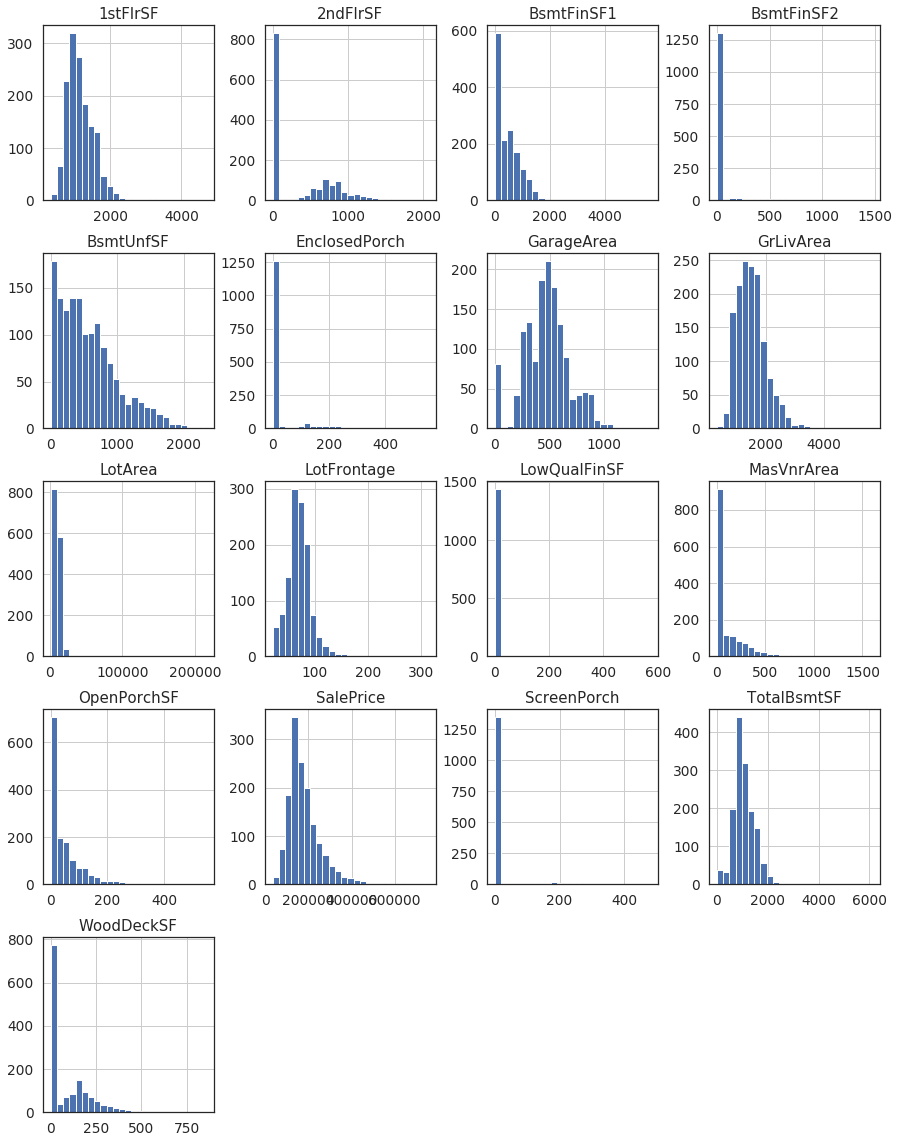

In [6]:
_=housing[cont_feats].hist(figsize = (15,20),bins=25)

### SalePrice (target variable)

In [7]:
from scipy import stats

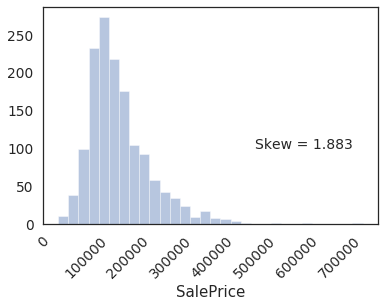

In [8]:
sns.distplot(housing.SalePrice, kde=False, bins=30)
plt.text(x=5e5, y=100,s='Skew = %.3f' %(housing.SalePrice.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution has a postive skew.  Let apply a log tranform.

In [9]:
housing['log1p(SalePrice)'] = np.log1p(housing['SalePrice'])

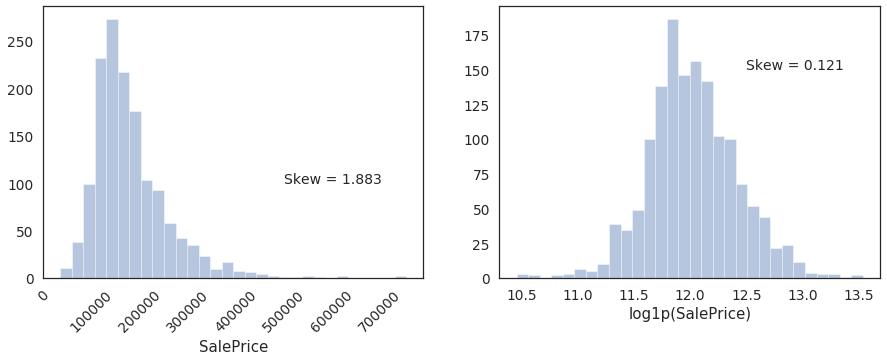

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing.SalePrice, kde=False, bins=30)
plt.text(x=5e5, y=100,s='Skew = %.3f' %(housing.SalePrice.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

plt.subplot(1,2,2)
sns.distplot(housing['log1p(SalePrice)'], kde=False, bins=30)
_=plt.text(x=12.5, y=150,s='Skew = %.3f' %(housing['log1p(SalePrice)'].skew()),fontdict={'fontsize':14})

Looks close to normal after tranforming.

### GrLivArea

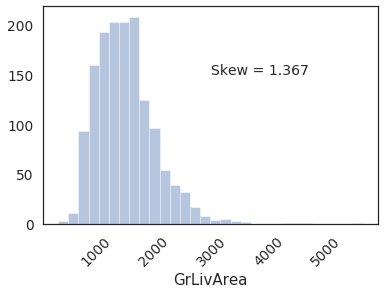

In [11]:
sns.distplot(housing.GrLivArea, kde=False, bins=30)
plt.text(x=3000, y=150,s='Skew = %.3f' %(housing.GrLivArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution has positve skew.

Text(0, 0.5, 'SalePrice')

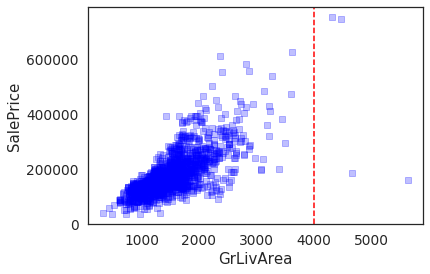

In [12]:
plt.scatter(housing.GrLivArea, housing.SalePrice, c='blue',marker = 's',alpha=0.25)
plt.axvline(x=4000,color='red',linestyle='--')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

Lets remove examples that have GrLivArea > 4000

In [13]:
outlier = pd.DataFrame()
out_var = []
outlier['GrLivArea'] = housing.GrLivArea > 4000
out_var.append('GrLivArea')

Text(0.5, 1.0, 'After removing GrLivArea > 4000')

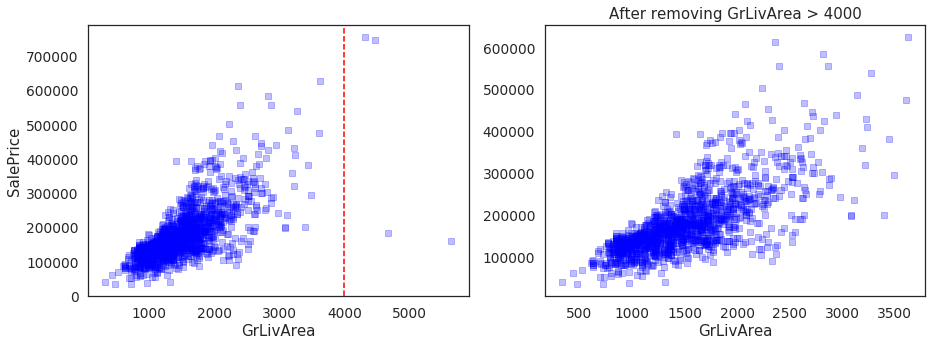

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(housing.GrLivArea, housing.SalePrice, c='blue',marker = 's',alpha=0.25)
plt.axvline(x=4000,color='red',linestyle='--')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.subplot(1,2,2)
plt.scatter(housing[~outlier.any(axis=1)].GrLivArea, housing[~outlier.any(axis=1)].SalePrice, c='blue',marker = 's',alpha=0.25)
plt.xlabel('GrLivArea')
plt.ylabel('')
plt.title('After removing GrLivArea > 4000')

No apparent outliers in the right scatter plot

Lets also apply log tranform to GrLivArea.

In [15]:
housing['log1p(GrLivArea)'] = np.log1p(housing.GrLivArea)

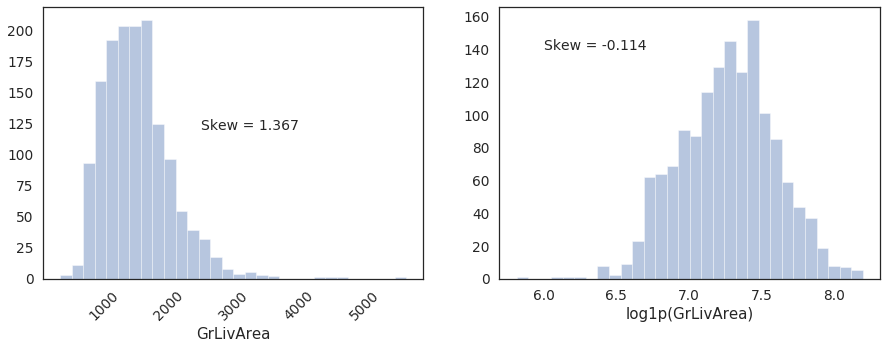

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing.GrLivArea, kde=False, bins=30)
plt.text(x=2500, y=120,s='Skew = %.3f' %(housing.GrLivArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

plt.subplot(1,2,2)
sns.distplot(np.log1p(housing[~outlier.any(axis=1)].GrLivArea), kde=False, bins=30)
_=plt.text(x=6, y=140,s='Skew = %.3f' %(np.log1p(housing[~outlier.any(axis=1)].GrLivArea).skew()),fontdict={'fontsize':14})
_=plt.xlabel('log1p(GrLivArea)')

Looks close to normal after log transform.

### GarageArea

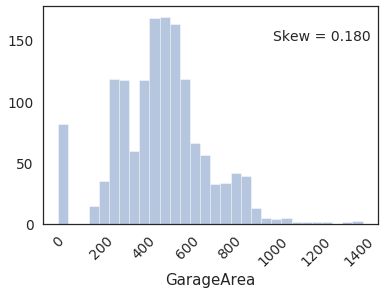

In [17]:
sns.distplot(housing.GarageArea, kde=False, bins=30)
plt.text(x=1000, y=150,s='Skew = %.3f' %(housing.GarageArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distibution looks reasonably normal.

Text(0, 0.5, 'SalePrice')

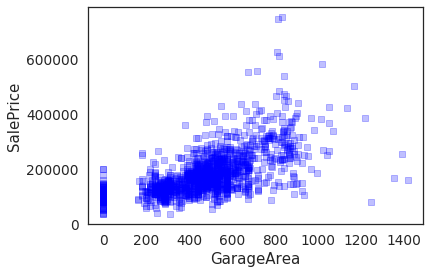

In [18]:
plt.scatter(housing.GarageArea, 
            housing.SalePrice, c='blue',marker = 's',alpha=0.25)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')

No apparent outliers in the scatter plot

### LotArea

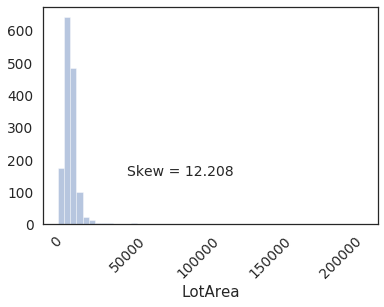

In [19]:
sns.distplot(housing.LotArea, kde=False, bins=50)
plt.text(x=50000, y=150,s='Skew = %.3f' %(housing.LotArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution is highly skewed due to outliers.

Text(0, 0.5, 'SalePrice')

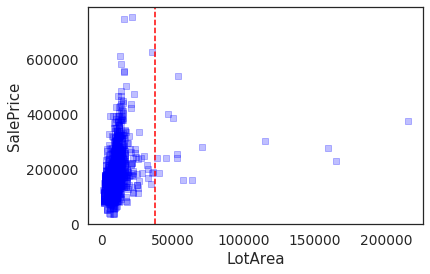

In [20]:
plt.scatter(housing.LotArea, 
            housing.SalePrice, c='blue',marker = 's',alpha=0.25)
percentile = np.percentile(housing.LotArea,99) # value at 99th percentile
plt.axvline(x=percentile,color='red',linestyle='--')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')

Text(0.5, 1.0, 'After removing Lot Area > 37568 sq.ft.')

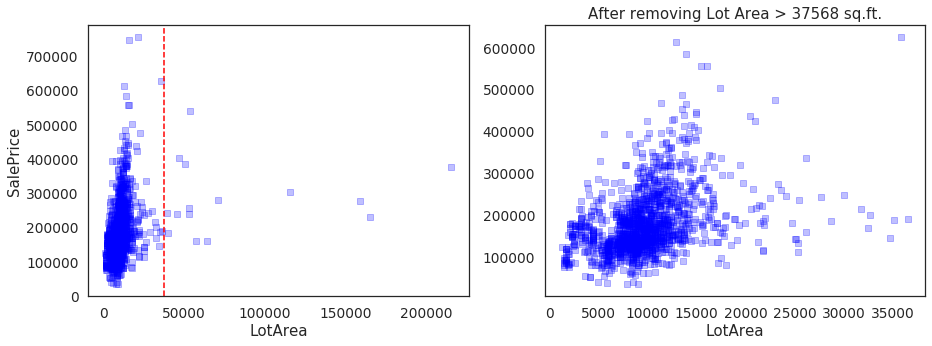

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(housing.LotArea, 
            housing.SalePrice, 
            c='blue',marker = 's',alpha=0.25)
plt.axvline(x=percentile,color='red',linestyle='--')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')

outlier['LotArea'] = housing.LotArea > percentile # 3e4

plt.subplot(1,2,2)
plt.scatter(housing[~outlier.any(axis=1)].LotArea, housing[~outlier.any(axis=1)].SalePrice, c='blue',marker = 's',alpha=0.25)
plt.xlabel('LotArea')
plt.ylabel('')
plt.title('After removing Lot Area > %.0f sq.ft.' %(percentile))

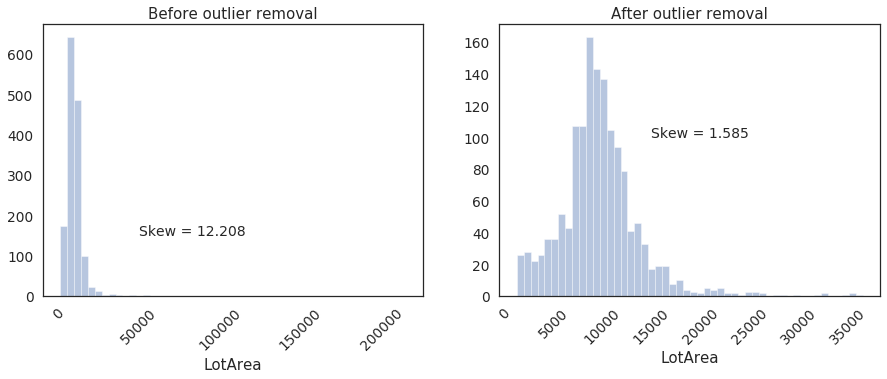

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing.LotArea, kde=False, bins=50)
plt.text(x=50000, y=150,s='Skew = %.3f' %(housing.LotArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)
_=plt.title('Before outlier removal')

plt.subplot(1,2,2)
sns.distplot(housing[~outlier.any(axis=1)]['LotArea'], kde=False, bins=50)
plt.text(x=15000, y=100,s='Skew = %.3f' %(housing[~outlier.any(axis=1)]['LotArea'].skew()),fontdict={'fontsize':14})
_=plt.title('After outlier removal')
_=plt.xticks(rotation = 45)

Skeweness improved considerably after removing outliers

Distribution has looks reasonably normal.

In [23]:
print('Number of examples before outlier removal: ',housing.shape[0])
print('Number of examples after outlier removal: ',housing[~outlier.any(axis=1)].shape[0])
print('%i examples are excluded' %(housing.shape[0]-housing[~outlier.any(axis=1)].shape[0]))

Number of examples before outlier removal:  1460
Number of examples after outlier removal:  1443
17 examples are excluded


In [24]:
housing = housing[~outlier.any(axis=1)]

For more advanced methods of dealing with outliers, ref to:  
    1. https://pyod.readthedocs.io/en/latest/  
    2. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In the next step we will treat missing values.

### **1.2. Missing Values**

### **1.2.1. Categorical features**
Lets first treat missing values in the categorical features  

In [25]:
from collections import defaultdict
FEATURES = defaultdict(list)

**MSSubclass** is a categorical feature but it got loaded as a numerical feature, so lets change it to categorical.

In [26]:
housing['MSSubClass'] = housing['MSSubClass'].astype(str)

In [27]:
missing_vals_cat = pd.DataFrame(columns=['Feature', '# of missing vals','% of missing vals'])
for feature, numNan in housing.isnull().sum().iteritems():
    if housing[feature].dtypes == 'object':
        FEATURES['cat'].append(feature)
        if numNan != 0:
            missing_vals_cat = pd.concat([missing_vals_cat,pd.DataFrame([feature,numNan,(numNan/housing.shape[0])*100],
                                                                        index=['Feature', '# of missing vals','% of missing vals']).T])
            
missing_vals_cat.sort_values(by=['% of missing vals'],ascending=False).reset_index(drop=True)

,Feature,# of missing vals,% of missing vals
0,PoolQC,1438,99.6535
1,MiscFeature,1391,96.3964
2,Alley,1352,93.6937
3,Fence,1163,80.596
4,FireplaceQu,690,47.817
5,GarageType,81,5.61331
6,GarageFinish,81,5.61331
7,GarageQual,81,5.61331
8,GarageCond,81,5.61331
9,BsmtExposure,38,2.6334


There are two categorical features, **Electrical** and **MasVnrType**, that have missing values. Both have insignificant amounts of missing values (0.072% and 0.51%), hence it will be reasonable to impute them with the most frequently occuring category.

All other features have "meaningful" missing values. For example, if a house does not have a basement, all features related basement are going to be null values. Hence, replace those missing values in another category called "**Missing**".

### Electrical & MasVnrType

Text(0.5, 1.0, 'MasVnrType')

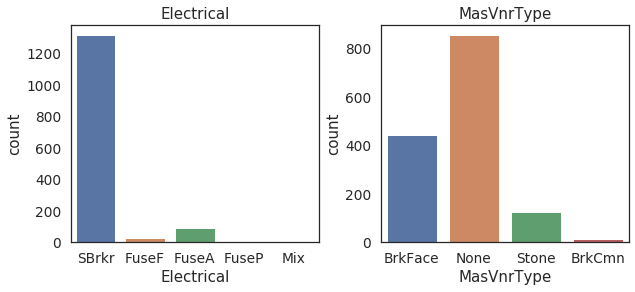

In [28]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10,4))
fig.subplots_adjust(wspace=0.25)
sns.countplot(x='Electrical',data=housing,ax=ax1)
ax1.set_title('Electrical')
sns.countplot(x='MasVnrType',data=housing,ax=ax2)
ax2.set_title('MasVnrType')

***SBrkr*** is the most frequent category in the **Electrical**.

***None*** is the most frequent category in **MasVnrType**.

Impute the missing categories with most frequently occuring ones.

In [29]:
def Impute(housing,attrib=['Electrical','MasVnrType']):
    #housing = housing[FEATURES['cat']].copy()
    for a in attrib:
        mode = housing[a].mode()[0]
        housing[a] = housing[a].fillna(mode)
    
    for col in FEATURES['cat']:
        housing[col].fillna('Missing',inplace=True)

    return housing

### Check if there are still missing values in the categorical features.

In [30]:
housing = Impute(housing)
housing[FEATURES['cat']].isnull().sum()

MSSubClass       0
MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

### **1.2.2. Numerical Features**

In [31]:
missing_vals_num = pd.DataFrame(columns=['Feature','# of missing values','% of missing values'])
for feature, numNan in housing.isnull().sum().iteritems():
    if housing[feature].dtypes!= 'object' and 'SalePrice' not in feature:
        FEATURES['num'].append(feature)
        if numNan != 0:
            missing_vals_num = pd.concat([missing_vals_num,
                                          pd.DataFrame([feature,numNan,
                                                        (numNan/housing.shape[0])*100],
                                                       index=['Feature','# of missing values','% of missing values']).T])

missing_vals_num.reset_index(drop = True).sort_values(by='# of missing values',ascending=False)

,Feature,# of missing values,% of missing values
0,LotFrontage,253,17.5329
2,GarageYrBlt,81,5.61331
1,MasVnrArea,8,0.554401


**MasVnrArea**: Since the most common category (None) was imputed for the missing values in the cat feature, **MasVnrType**, it will make sense to impute missing values in **MasVnrArea** with median **MasVnrArea** value of houses that have "None" as the **MasVnrType**.

In [32]:
MedianMasVnrArea = housing[housing['MasVnrType'] == 'None']['MasVnrArea'].median()
housing['MasVnrArea'].fillna(MedianMasVnrArea,inplace=True)

**GarageYrBlt**: these are same rows which have missing values in other garage related features, indicating that these houses do not have a garage. Imputing median value is a safe option, as these houses have already been flagged as missing a garage in the categorical features.

In [33]:
housing['GarageYrBlt'].fillna(housing['GarageYrBlt'].median(),inplace=True)
print("Median GarageYrBlt: ",housing['GarageYrBlt'].median())

Median GarageYrBlt:  1980.0


**LotForntage**: missing values needs to be handled more carefully as they amount to 17.73% of the total oberservation.

   - Let's take a look at the other three features associated with Lot: LotConfig, LotShape, and LotArea

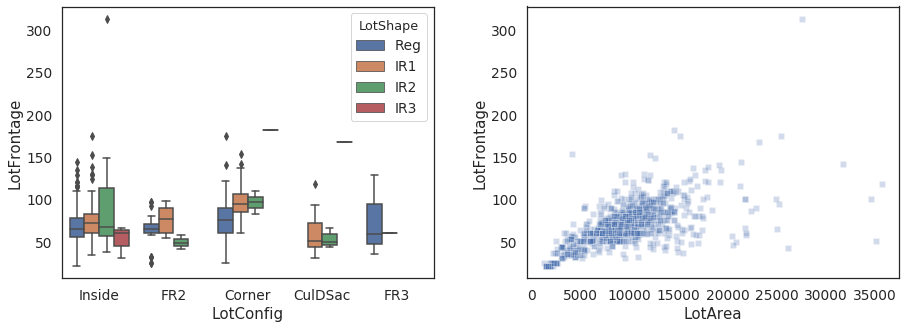

In [34]:
plt.figure(figsize = (15,5))
plt.subplots_adjust(wspace=0.25)
plt.subplot(1,2,1)
sns.boxplot(x='LotConfig',y='LotFrontage',data=housing,hue='LotShape')
plt.subplot(1,2,2)
sns.scatterplot(x='LotArea',y='LotFrontage',data=housing,marker='s',alpha=0.25)

### Impute missing LotFrontage in the following way:  
   - Group the data by **LotShape** and **LotConfig** and compute group specific median **LotFrontage**. 
   - Impute missing **LotFrontage** with group specific median LotFrontage values.

In [35]:
housing.groupby(['LotConfig','LotShape'])['LotFrontage'].median().to_dict()

{('Corner', 'IR1'): 94.5,
 ('Corner', 'IR2'): 96.0,
 ('Corner', 'IR3'): 182.0,
 ('Corner', 'Reg'): 75.0,
 ('CulDSac', 'IR1'): 50.0,
 ('CulDSac', 'IR2'): 49.0,
 ('CulDSac', 'IR3'): 168.0,
 ('CulDSac', 'Reg'): nan,
 ('FR2', 'IR1'): 77.0,
 ('FR2', 'IR2'): 48.0,
 ('FR2', 'Reg'): 64.5,
 ('FR3', 'IR1'): 60.0,
 ('FR3', 'Reg'): 59.0,
 ('Inside', 'IR1'): 71.5,
 ('Inside', 'IR2'): 67.0,
 ('Inside', 'IR3'): 60.0,
 ('Inside', 'Reg'): 65.0}

In [36]:
def imputeLotFrontage(housing):
    LotFrontageImuter = housing.groupby(['LotConfig','LotShape'])['LotFrontage'].median().to_dict()
    for key,val in LotFrontageImuter.items():
        LotConfig,LotShape = key
        housing.loc[(housing['LotFrontage'].isnull()) & (housing['LotConfig']==LotConfig) & (housing['LotShape']==LotShape),['LotFrontage']] = val
        
    housing.loc[housing['LotFrontage'].isnull(),'LotFrontage'] = housing['LotFrontage'].median()
    return housing

In [37]:
housing = imputeLotFrontage(housing)

In [38]:
housing.isnull().sum().sum()

0

**Data cleaning is done at this point.**

Next, we will add more data to the dataset from other sources.

### **1.3. Data Augmentation**
In this part, we will add more features to the dataset by gathering data from other sources like **Google's Geocoding API** and **uszipcode** library. 

### Count number of unique categories per categorical feature

In [39]:
unique_cats = defaultdict(int)

for col in housing.columns:
    if housing[col].dtypes == 'object':
        unique_cats[col] = housing[col].nunique()
        #print('{0}:\t\t {1} unique categories'.format(col,housing_cat[col].nunique()))

num_unique_cats = pd.Series(unique_cats)
num_unique_cats.sort_values(ascending = False)

Neighborhood     25
Exterior2nd      16
MSSubClass       15
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
GarageType        7
Functional        7
BsmtFinType1      7
BsmtFinType2      7
Heating           6
RoofStyle         6
RoofMatl          6
SaleCondition     6
Foundation        6
FireplaceQu       6
GarageCond        6
GarageQual        6
MSZoning          5
LotConfig         5
MiscFeature       5
Fence             5
BldgType          5
HeatingQC         5
ExterCond         5
Electrical        5
BsmtQual          5
BsmtCond          5
BsmtExposure      5
MasVnrType        4
LotShape          4
ExterQual         4
KitchenQual       4
PoolQC            4
GarageFinish      4
LandContour       4
Alley             3
LandSlope         3
PavedDrive        3
Utilities         2
Street            2
CentralAir        2
dtype: int64

Neighborhood has most number of unique categories. The categories are some sort of location names.  

### **1.3.1. Google API: Geocoding**

In this section, we will extract Latitude and Longitude coordinates, and zipcodes from Google's Geocoding API.

In [40]:
import googlemaps
import json
# Import the googlemaps API key
with open('../data/keys.json') as file:
    keys = json.load(file)
    
gmaps = googlemaps.Client(key=keys['geocoding'])

In [41]:
# List of neighborhoods
housing.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [42]:
neighborhoods = {"CollgCr":"College Creek","Veenker":"Veenker",
                 "Crawfor":"Crawford","NoRidge":"Northridge",
                 "Mitchel":"Mitchell","Somerst":"Somerset",
                 "NWAmes":"Northwest Ames","OldTown":"Old Town",
                 "BrkSide":"Brookside","Sawyer":"Sawyer",
                 "NridgHt":"Northridge Heights","NAmes":"North Ames",
                 "SawyerW":"Sawyer West","IDOTRR":"Iowa DOT and Rail Road",
                 "MeadowV":"Meadow Village","Edwards":"Edwards",
                 "Timber":"Timberland","Gilbert":"Gilbert",
                 "StoneBr":"Stone Brook","ClearCr":"Clear Creek",
                 "NPkVill":"Northpark Villa","Blmngtn":"Bloomington Heights",
                 "BrDale":"Briardale","SWISU":"South & West of Iowa State University",
                 "Blueste":"Bluestem"}

Let's create a separate dataframe with unique Neighborhood categories

In [43]:
geo_df = pd.DataFrame(housing.Neighborhood.unique(),columns=['Neighborhood'])
geo_df.head()

,Neighborhood
0,CollgCr
1,Veenker
2,Crawfor
3,NoRidge
4,Mitchel


In [44]:
import re
def getGeoInfo(Neighborhood, output):
    '''
     Enter the Neighborhood and the kind of output you want (lat,lng, or zipcode)
    '''
    def getZipCode(formatted_address):
        substr = re.findall('IA \d{5}, USA',formatted_address)
        if len(substr) == 0:
            return 'Missing'
        else:
            return re.findall('\d{5}',substr[0])[0]

    geocode_result = gmaps.geocode(neighborhoods[Neighborhood]+', Ames, IA')
    
    i = 0
    while True:
        if i == len(geocode_result):
            idx = None
            break
        elif 'IA' in geocode_result[i]['formatted_address']:
            idx = i
            break
        i += 1
        
    lat = geocode_result[idx]['geometry']['location']['lat']
    lng = geocode_result[idx]['geometry']['location']['lng']
    zipcode = getZipCode(geocode_result[idx]['formatted_address'])

    if output == 'lat':
        return lat
    elif output == 'lng':
        return lng
    elif output == 'zipcode':
        return zipcode
    else:
        return 'invalid output!'

In [45]:
geo_df['Lat'] = geo_df['Neighborhood'].apply(getGeoInfo,output='lat')
geo_df['Lng'] = geo_df['Neighborhood'].apply(getGeoInfo,output='lng')
geo_df['zipcode'] = geo_df['Neighborhood'].apply(getGeoInfo,output='zipcode')

In [46]:
geo_df

,Neighborhood,Lat,Lng,zipcode
0,CollgCr,42.022197,-93.651510,Missing
1,Veenker,42.041304,-93.650302,50011
2,Crawfor,42.018614,-93.648898,50014
3,NoRidge,42.047831,-93.646745,50010
4,Mitchel,41.990308,-93.601053,50010
5,Somerst,42.052628,-93.644582,50010
6,NWAmes,42.038277,-93.625770,50010
7,OldTown,42.029046,-93.614340,50010
8,BrkSide,42.028653,-93.630386,50010
9,Sawyer,42.033903,-93.677066,50014


In geo_df, there are two Neighborhoods (CollgCr, NPkVill) for which Google's gecoding API was not able to provide the zipcode.

Lets look at Lat vs. Lng scatter plot to see which neighborhoods are close to those with missing zipcode. 

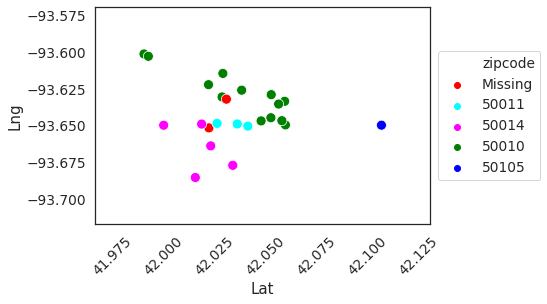

In [47]:
sns.scatterplot(x='Lat',y='Lng',
                data=geo_df,
                hue='zipcode',
                palette=['red','cyan','magenta','green','blue'],
                alpha=1,s=100)
plt.legend(loc='center right',bbox_to_anchor = (1.35,0.5))
_=plt.xticks(rotation=45)

It will be reasonable to impute missing zipcodes with the closest neighbors, but there is another library that can provide zipcode info based on geo coordinates. 

It is the **uszipcode** library https://pypi.org/project/uszipcode/

This library can be used to extract demographic information of different locations in US.

### **1.3.2. uszipcode**
In this section, we will impute the missing zipcode, as well as augment our dataset with more features like popution density, total population, median household income, total number of housing units, etc.

In [48]:
from uszipcode import SearchEngine

In [49]:
def getMoreFeat(a,b):
    '''
    Can take zipcode or [lat,lng] as inputs (a) and return requested information about location, 
    The information requested should be specifed as the second argument (b).

    Acceptable requests are:'lat', 'lng', 
                            'population', 'zipcode', 
                            'population_density','housing_units',
                            'occupied_housing_units', 'median_home_value'
                            'median_household_income'
    
    '''
    def getZipCode(a):
        geo_info = search.by_coordinates(a[0],a[1],radius=5)
        i = 0
        while True:
            if i == len(geo_info):
                idx = None
                break
            elif (geo_info[i].post_office_city == 'Ames, IA') and (geo_info[i].major_city == 'Ames') and (geo_info[i].common_city_list[0] == 'Ames'):
                idx = i
                break
            i += 1
            
        if idx == None:
            print("Coordinates don't belong to Ames, IA. NaN returned")
            return np.nan
        else:
            return geo_info[idx].to_dict()[b]
    
    def getRequest(zipcode,b):
        geo_info = search.by_zipcode(zipcode)
        return geo_info.to_dict()[b]
        
        
    search = SearchEngine(simple_zipcode=True)
    
    if b == 'zipcode': 
        return getZipCode(a)
    elif b in ['lat', 'lng', 'population', 'zipcode', 
                  'population_density','housing_units',
                  'occupied_housing_units', 'median_home_value',
                  'median_household_income']:
        return getRequest(a,b)
        

In [50]:
geo_df.loc[geo_df.zipcode=='Missing','zipcode'] = geo_df.loc[geo_df.zipcode=='Missing',['Lat','Lng']].apply(getMoreFeat,axis=1,b='zipcode')

In [51]:
geo_df['median_household_income'] = geo_df['zipcode'].apply(getMoreFeat,b='median_household_income')
geo_df['median_home_value'] = geo_df['zipcode'].apply(getMoreFeat,b='median_home_value')
geo_df

,Neighborhood,Lat,Lng,zipcode,median_household_income,median_home_value
0,CollgCr,42.022197,-93.651510,50010,48189.0,165300.0
1,Veenker,42.041304,-93.650302,50011,NaN,NaN
2,Crawfor,42.018614,-93.648898,50014,37661.0,212500.0
3,NoRidge,42.047831,-93.646745,50010,48189.0,165300.0
4,Mitchel,41.990308,-93.601053,50010,48189.0,165300.0
5,Somerst,42.052628,-93.644582,50010,48189.0,165300.0
6,NWAmes,42.038277,-93.625770,50010,48189.0,165300.0
7,OldTown,42.029046,-93.614340,50010,48189.0,165300.0
8,BrkSide,42.028653,-93.630386,50010,48189.0,165300.0
9,Sawyer,42.033903,-93.677066,50014,37661.0,212500.0


There are missing values in median_household_income and median_home_value column. 

Lets impute missing values using K-nearest neighbor imputer.

In [52]:
from missingpy import KNNImputer

In [53]:
geo_df['zipcode'] = geo_df.zipcode.astype(int)

In [54]:
imputer = KNNImputer(n_neighbors=2,weights='distance')

In [55]:
geo_df.set_index('Neighborhood',inplace=True)
geo_df = pd.DataFrame(imputer.fit_transform(geo_df),columns=geo_df.columns,index=geo_df.index)
geo_df.reset_index(inplace=True)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


In [56]:
geo_df

,Neighborhood,Lat,Lng,zipcode,median_household_income,median_home_value
0,CollgCr,42.022197,-93.651510,50010.0,48189.0,165300.0
1,Veenker,42.041304,-93.650302,50011.0,48189.0,165300.0
2,Crawfor,42.018614,-93.648898,50014.0,37661.0,212500.0
3,NoRidge,42.047831,-93.646745,50010.0,48189.0,165300.0
4,Mitchel,41.990308,-93.601053,50010.0,48189.0,165300.0
5,Somerst,42.052628,-93.644582,50010.0,48189.0,165300.0
6,NWAmes,42.038277,-93.625770,50010.0,48189.0,165300.0
7,OldTown,42.029046,-93.614340,50010.0,48189.0,165300.0
8,BrkSide,42.028653,-93.630386,50010.0,48189.0,165300.0
9,Sawyer,42.033903,-93.677066,50014.0,37661.0,212500.0


In [57]:
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
Neighborhood               25 non-null object
Lat                        25 non-null float64
Lng                        25 non-null float64
zipcode                    25 non-null float64
median_household_income    25 non-null float64
median_home_value          25 non-null float64
dtypes: float64(5), object(1)
memory usage: 1.2+ KB


Now that geo_df, which includes geographical and demographical information, is ready. Lets merge it with the main dataframe 

Let's merge the addtional features to the main dataset.

In [58]:
housing.reset_index(inplace=True)
housing = housing.merge(geo_df,how='left')
housing.set_index('Id',inplace=True)

In [59]:
## Add newly added numerical features to FEATURES
for feature in housing.columns:
    if (housing[feature].dtypes!= 'object') and (feature not in FEATURES['num']) and ('SalePrice' not in feature):
        FEATURES['num'].append(feature)

In [60]:
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,SalePrice,log1p(SalePrice),log1p(GrLivArea),Lat,Lng,zipcode,median_household_income,median_home_value
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Missing,Reg,Lvl,AllPub,Inside,...,WD,Normal,208500,12.247699,7.444833,42.022197,-93.651510,50010.0,48189.0,165300.0
2,20,RL,80.0,9600,Pave,Missing,Reg,Lvl,AllPub,FR2,...,WD,Normal,181500,12.109016,7.141245,42.041304,-93.650302,50011.0,48189.0,165300.0
3,60,RL,68.0,11250,Pave,Missing,IR1,Lvl,AllPub,Inside,...,WD,Normal,223500,12.317171,7.488294,42.022197,-93.651510,50010.0,48189.0,165300.0
4,70,RL,60.0,9550,Pave,Missing,IR1,Lvl,AllPub,Corner,...,WD,Abnorml,140000,11.849405,7.448916,42.018614,-93.648898,50014.0,37661.0,212500.0
5,60,RL,84.0,14260,Pave,Missing,IR1,Lvl,AllPub,FR2,...,WD,Normal,250000,12.429220,7.695758,42.047831,-93.646745,50010.0,48189.0,165300.0


Correlations of the newly added geographic and demograpic features with the target variable. 

Text(0.5, 1, 'Correlation Matrix')

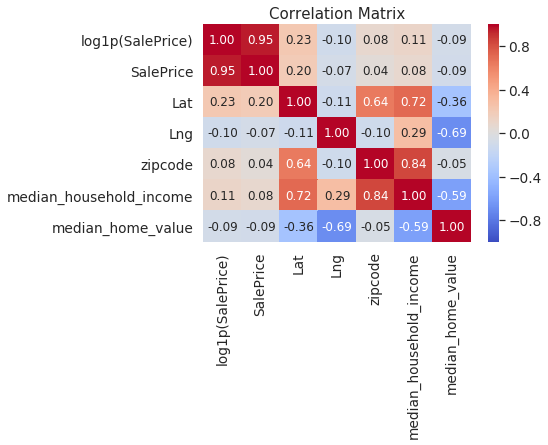

In [61]:
plt.figure(figsize=(6,4))
sns.heatmap(housing[['log1p(SalePrice)','SalePrice','Lat','Lng','zipcode','median_household_income','median_home_value']].corr(),
           vmin=-1,vmax=1,cmap='coolwarm',annot=True,annot_kws=dict(size=12),fmt='.2f')
plt.title('Correlation Matrix')

Correlations are high, but lets keep these features for now. We will come back to this later.

In [62]:
print('Dimensions of the dataset',housing[FEATURES['num']+FEATURES['cat']].shape)

Dimensions of the dataset (1443, 85)


**At this point, data is free of outliers and missing values.**